# Plot N versus z Distributions in the extragalactic catalogs

<br>Owner: **Eve Kovacs** ([@evevkovacs](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@evevkovacs))
<br>Last Verified to Run: Nov 30, 2018 by @yymao

This notebook demonstrates how to make number-density versus redshift plots from the extragalactic catalog (protoDC2, cosmoDC2).

### Learning Objectives:
After working through and studying this Notebook you should be able to
1. Select data quantities to plot
2. Define and apply filters to the data selection
3. Use the GCRCatalogs iterator for large catalogs
4. Aggregate histograms on the fly
5. Loop over sub-plots [Advanced]
6. Use a private version of GCRCatalogs [Advanced]

The functions in this notebook have been selected from the [NumberDensityVersusRedshift](https://github.com/LSSTDESC/descqa/blob/master/descqa/NumberDensityVersusRedshift.py) DESCQA test.

In [1]:
from itertools import zip_longest

import numpy as np

from GCR import GCRQuery
import GCRCatalogs                                                                                               

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the catalog using GCRCatalogs.  We want 'protoDC2'.  The default config asks the catalog reader to check the catalog against a stored MD5 checksum.  This is in general a good feature, but it takes 30-40 seconds and we'll want to skip that for this tutorial.  So we here use 'protoDC2_test' configuration which skips the MD5 checksum.

In [2]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

Define a function to fetch the catalog data for the desired redshift quantity and magnitude in  a specified band. Data will be filtered to lie between selected redshift bounds. Filter magnitudes may come from several specified filters, in the given preferred order.

This function uses a GCR iterator so that data from a very large catalog can be processed. This is not a problem for protoDC2, but will be an issue for cosmoDC2, since that catalog will be too large to fit into memory. The iterator returns the catalog data in chunks. Histogram arrays to store the chunks have to be pre-allocated and accumulated on the fly for each chunk.

Note that because we are accumulating the histograms as we process the data, this function needs arguments that define the binning and the desired shape of the sub-plot array.

We accumulate sumz_array so that it will be possible to calculate the mean of z for each bin.

In [3]:
def get_mags_and_redshift(gc, mag_lo, mag_hi, band='r', z='redshift_true', zlo=0., zhi=1.1, 
                          nrows=3, ncolumns=2, Nzbins=20):
    # Set up quantities to fetch
    possible_mag_fields = ('mag_true_{}_lsst', 'mag_true_{}_sdss', 'mag_true_{}_des')
    mag_fields = [f.format(band) for f in possible_mag_fields]
    mag_field = gc.first_available(*mag_fields)
    required_quantities = [mag_field, z]
    # Set up binning 
    zbins = np.linspace(zlo, zhi, Nzbins+1)
    filters = [(lambda z: (z > zlo) & (z < zhi), z)]  # Filter on selected redshift range
    
    # Initialize arrays for storing histogram sums
    N_array = np.zeros((nrows, ncolumns, len(zbins)-1), dtype=np.int)
    sumz_array = np.zeros((nrows, ncolumns, len(zbins)-1))
    # Get catalog data by looping over data iterator (needed for large catalogs) and aggregate histograms
    for catalog_data in gc.get_quantities(required_quantities, filters=filters, return_iterator=True):
        catalog_data = GCRQuery(*((np.isfinite, col) for col in catalog_data)).filter(catalog_data)
        for n, (cut_lo, cut_hi, N, sumz) in enumerate(zip_longest(
                mag_lo,
                mag_hi,
                N_array.reshape(-1, N_array.shape[-1]), # Flatten all but last dimension of array
                sumz_array.reshape(-1, sumz_array.shape[-1]),
        )):
            if cut_lo is None or cut_hi is None:
                continue
            cuts = [
                '{} < {}'.format(mag_field, cut_lo),
                '{} >= {}'.format(mag_field, cut_hi),
            ]
            z_this = catalog_data[z][GCRQuery(*cuts).mask(catalog_data)]

            # Bin catalog_data and accumulate subplot histograms
            N += np.histogram(z_this, bins=zbins)[0]
            sumz += np.histogram(z_this, bins=zbins, weights=z_this)[0]
        
    return zbins, N_array, sumz_array

Now select some magnitude cuts, choose a 2 column array for the subplots, and call the function to accumulate the histogram arrays.

In [4]:
# Select some magnitude cuts and fill the histogram arrays for 2-column plots
mlo = 25
mhi = 19

mag_lo = 1 + np.arange(mhi, mlo, dtype=np.float)
mag_hi = mhi + np.zeros_like(mag_lo)

ncolumns = 2
nrows = (len(mag_lo) + ncolumns - 1)//ncolumns

Nzbins = 10 
zbins, N_array, sumz_array = get_mags_and_redshift(gc, mag_lo, mag_hi, Nzbins=Nzbins, nrows=nrows, ncolumns=ncolumns)

Define a function to make the plots using the accumulated histogram arrays. Statistical errors only are being used. A more realistic estimate would be provided by jack-knife errors which take into account the sample variance. The code for calculating the jack-knife errors is available in the [DESCQA test](https://github.com/LSSTDESC/descqa/blob/master/descqa/NumberDensityVersusRedshift.py).

In [5]:
def plot_N_vs_z(mag_lo, mag_hi, N_array, sumz_array, zbins, band='r', normed=True,
                nrows=3, ncolumns=2, figx_p=9, figy_p=11):
    fig, ax = plt.subplots(nrows, ncolumns, figsize=(figx_p, figy_p), sharex='col')
    for n, (ax_this, cut_lo, cut_hi, N, sumz) in \
            enumerate(zip_longest(ax.flat,
                                  mag_lo, 
                                  mag_hi,
                                  N_array.reshape(-1, N_array.shape[-1]),
                                  sumz_array.reshape(-1, sumz_array.shape[-1]),
                                  )):
        if cut_lo is None or cut_hi is None:  # cut_lo is None if mag_lo is exhausted
            ax_this.set_visible(False)
            continue

        cut_label = '{} $\leq$ {} $<$ {}'.format(cut_hi, band, cut_lo)
        meanz = sumz / N
        sumN = N.sum()
        covariance = np.diag(N)

        if normed:
            scale = sumN * (zbins[1:] - zbins[:-1])
            N = N/scale
            covariance = covariance/np.outer(scale, scale)

        Nerrors = np.sqrt(np.diag(covariance))

        ax_this.errorbar(meanz, N, yerr=Nerrors, label=cut_label, color='blue', fmt='o:', ms=4)
        decorate_subplot(ax_this, n, nrows, ncolumns, 'p(z|m)', 'z')

    plt.subplots_adjust(hspace=0)

In [6]:
def decorate_subplot(ax, nplot, nrows, ncolumns, ylabel, xlabel):
    # Add axes and legend              
    if nplot % ncolumns == 0:  # 1st column
        ax.set_ylabel('$'+ylabel+'$', size=16)

    if nplot+1 <= nplot - ncolumns:  # x scales for last ncol plots only
        # Print "noticks",nplot                                                  
        for axlabel in ax.get_xticklabels():                                    
            axlabel.set_visible(False)                                          
            # Prevent overlapping yaxis labels                                   
            ax.yaxis.get_major_ticks()[0].label1.set_visible(False)             
    else:                                                                       
        ax.set_xlabel('$'+xlabel+'$', size=16)                                   
        for axlabel in ax.get_xticklabels():                                    
            axlabel.set_visible(True)                                           
        ax.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10, numpoints=1)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


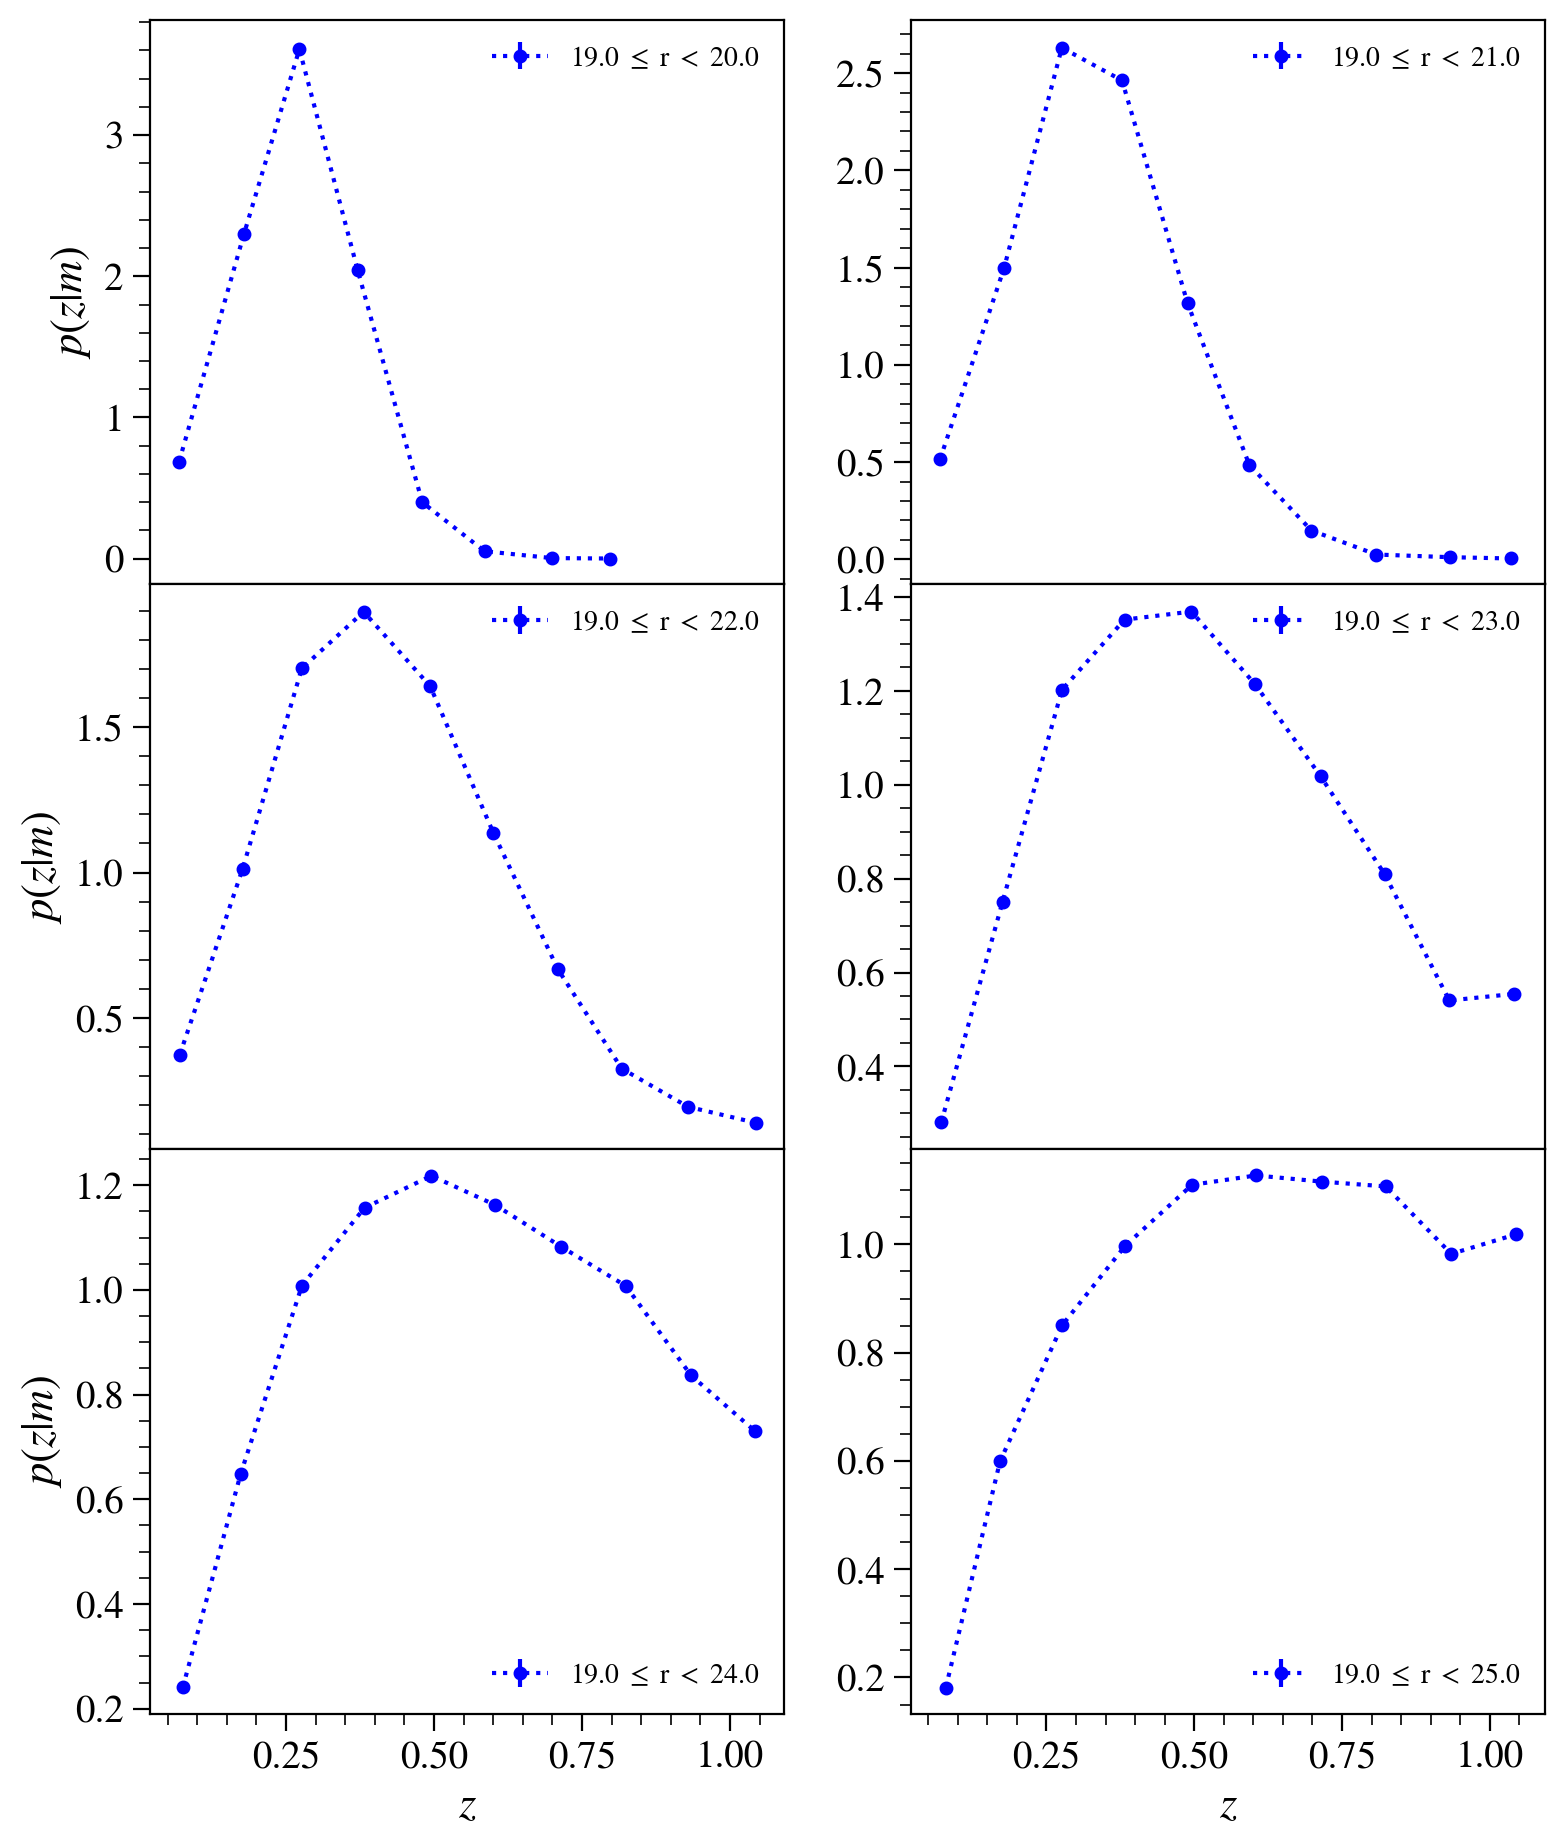

In [7]:
plot_N_vs_z(mag_lo, mag_hi, N_array, sumz_array, zbins, nrows=nrows, ncolumns=ncolumns, normed=True)

## Appendix: Using a development version of GCRCatalogs
In development, the extragalactic team often found it useful to refer to development versions of GCRCatalogs (gcr-catalogs).  Here's how one would do this.  If one had a private checkout of the GCRCatalogs repository, e.g., one had run
```
git clone https://github/com/LSSTDESC/gcr-catalogs /global/u1/k/kovacs/gcr-catalogs_v4x
```

Then you can explicitly manipulate your Python path to include this particular version as:

```
import sys
sys.path.insert(0, '/global/u1/k/kovacs/gcr-catalogs_v4x')
```

If you had a specific custom configuration file that you had written, called, 'proto-dc2_v4.15_test', you could load that configuration instead with

```
gc = GCRCatalogs.load_catalog('proto-dc2_v4.15_test')
```